In [13]:
# import dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.decomposition import PCA
import hvplot.pandas
import plotly.express as px

In [14]:
# import data
red = pd.read_csv('winequality-red.csv', sep=';')
white = pd.read_csv('winequality-white.csv', sep=';')
df = pd.concat([red,white], axis=0)


In [15]:
# compute binary outcome (high quality >=7)
df['high quality'] = np.where(df['quality']>6, 1, 0)
df.head(10)

# drop the quality column
df.drop(['quality'], axis=1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,high quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,0
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,0
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,0
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,1


In [16]:
# look for missing data --> there is none
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
high quality            0
dtype: int64

In [17]:
# split into training and test (70/30)
X = df.copy().drop('high quality', axis=1)
y = df['high quality']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=0, stratify = y )

In [18]:
# # use function to remove values that exceed cutoff ('outliers')
# # note, this procedure is meant for normally distributed data
# # in the literature there are nonparametric methods described.
# # e.g. 'Mahalanobis beyond normal distributions' by Joakim Ekstrom
# train = mahalanobis(X_train, y_train)

In [19]:
# Power Transformer Scaler to deal with data that is not normally distributed.
# This is essentially a Box-Cox procedure
scaler = PowerTransformer(method='yeo-johnson')
X_trSc = scaler.fit_transform(X_train)
X_teSc = scaler.fit_transform(X_test)


/Users/catherinesmith/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning:

divide by zero encountered in log



In [20]:
# perform Support Vector Classificiation
model = SVC()
model.fit(X_trSc, y_train)
y_pred = model.predict(X_teSc)
print('Balanced Accuracy Score: ',round(balanced_accuracy_score(y_test, y_pred),2),
'\nPrecision: ', round(precision_score(y_test, y_pred),2),
'\nRecall: ', round(recall_score(y_test, y_pred),2))


Balanced Accuracy Score:  1.0 
Precision:  1.0 
Recall:  1.0


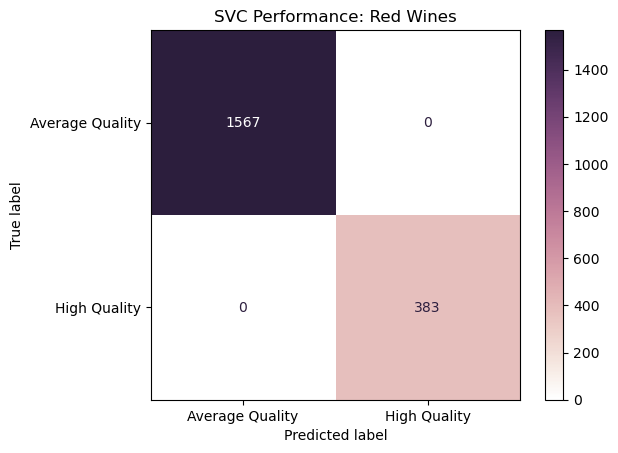

In [21]:
cm_plot = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
display_labels=['Average Quality', 'High Quality'])

cm_plot.plot(cmap = sns.cubehelix_palette(light=1, as_cmap=True))
plt.title('SVC Performance: Red Wines')
plt.savefig('static/images/cm_redWines')
plt.show()

In [35]:
# do PCA
pca = PCA(n_components=3)
pcs = pca.fit_transform(X_teSc)
pca_df = pd.DataFrame(data = pcs, columns = ['PC-1', 'PC-2', 'PC-3'])
pca_df.head()
pca.explained_variance_ratio_
pca_df['class'] = y_pred.tolist()
pca_df['class'] = np.where(pca_df['class']==0, 'Average Quality', 'High Quality')
pca.explained_variance_ratio_

array([0.27216773, 0.17880257, 0.14931058])

In [36]:
# plot PCA
pca_plot = pca_df.hvplot.scatter(
    x='PC-1',
    y='PC-2',
    hover_cols=['class'],
    by='class',
    color = ['#613969', '#DAA4AC'],
    title = "SVC of All Wines")

pca_plot

hvplot.save(pca_plot, 'static/images/SVC-scatter.html')

In [24]:
px.scatter_3d(pca_df,
x='PC-1',
y='PC-2',
z='PC-3',
color='class')